# Rappi Challenge Data Engineer
**Developer**: COLLANTE, Gerardo

# Librerías

In [311]:
# Data processing libraries
import pandas as pd
import numpy as np
from IPython.display import display
from humanize import intword
# Data plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import missingno as msno
import matplotlib.ticker as mtick
import plotly.express as px
# OS libraries
import os
import requests

# Variables

In [312]:
DEBUG = True
style = 'bmh'
plt.style.use(style)

# Carga de datos

In [446]:
DATADIR = 'data'
FILENAME = 'challenge_orders.csv'
PATH = os.path.join(DATADIR, FILENAME)

In [447]:
df = pd.read_csv(PATH, index_col=0, parse_dates=['CREATED_AT'])

## Comprobación de valores faltantes

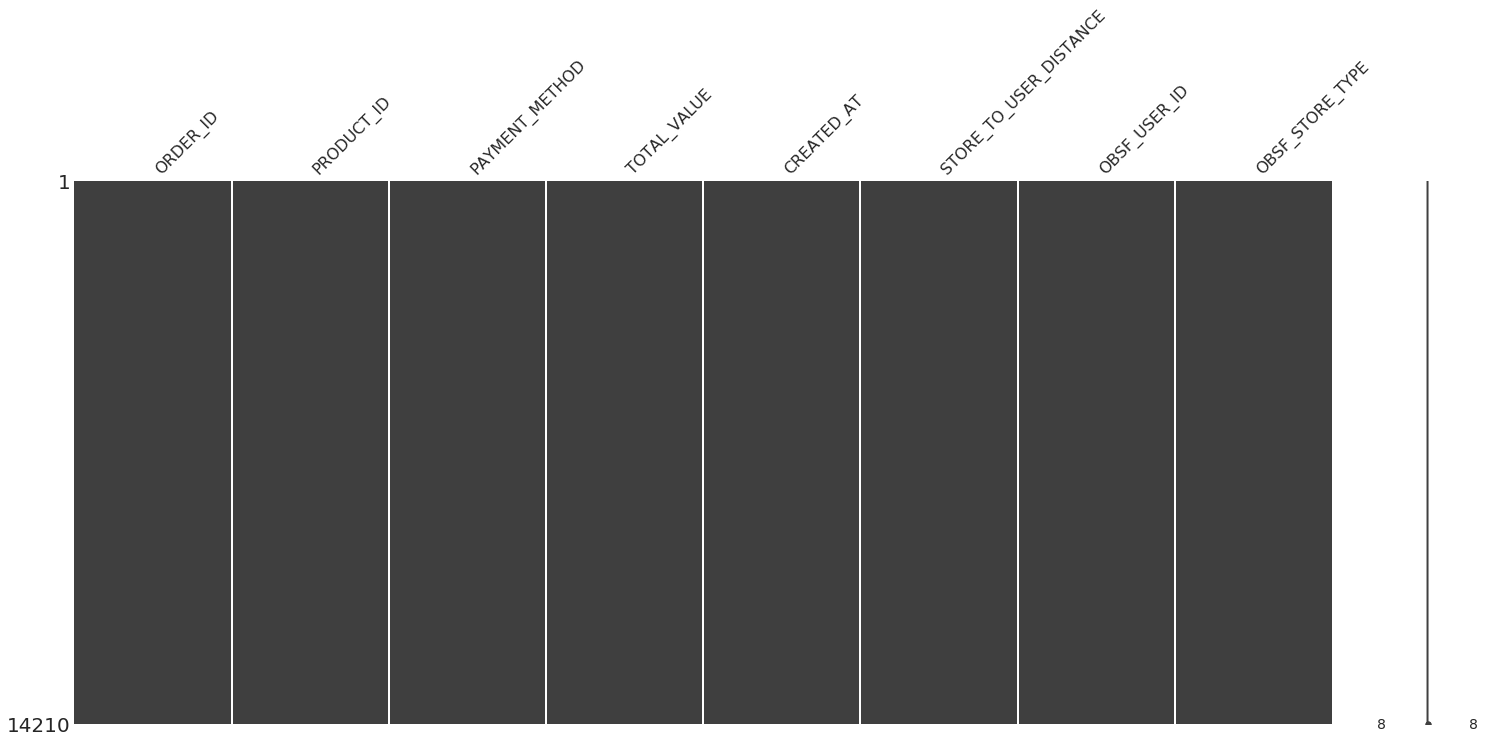

In [448]:
msno.matrix(df)

## Preprocesamiento

In [449]:
df.rename(columns={'ORDER_ID':'order', 
                   'PRODUCT_ID':'product', 
                   'PAYMENT_METHOD':'pay', 
                   'TOTAL_VALUE':'total', 
                   'CREATED_AT':'created', 
                   'STORE_TO_USER_DISTANCE':'dist', 
                   'OBSF_USER_ID':'user', 
                   'OBSF_STORE_TYPE':'store'}, inplace=True)
df.total = df.total.astype(int)
df.dist = df.dist.astype(int)

# Necesidades de negocio

In [450]:
APP_ID = 'd2847e56a8474a9fb4416b519b1447ce'
symbol = 'COP'
pretty = 'true'

In [318]:
def get_usd_cop(date:str):
    url = f'https://openexchangerates.org/api/historical/{date}.json?app_id={APP_ID} \
            &symbols={symbol}&prettyprint={pretty}'
    try:
        response = requests.get(url)
        usd = response.json()['rates'][symbol]
    except:
        usd = np.nan
        print('Sucedio un error')
    return float(usd)

In [451]:
# Get unique dates
dates = df.created.apply(lambda x: x.strftime('%Y-%m-%d')).unique()

In [326]:
try:
    # Load usd_df if exists
    pd.read_csv('usd.csv', index_col=0)
    print("CSV readed")
except FileNotFoundError:
    print("CSV does not exist.")
    # Create DataFrames
    usd_df = pd.DataFrame(columns = ["date", "usd"])
    #usd_df = pd.DataFrame(index=["date"], columns=["usd"])
    usd_df.set_index('date', inplace=True)
    print('DataFrame created.')
except:
    print("Other error")

CSV does not exist.
DataFrame created.


In [327]:
usd_df

,usd
date,


In [328]:
# Fill DataFrame
for index, date in enumerate(dates):
    try: 
        usd_df.loc[date,'usd']
    except:
        usd_df.loc[date]=[get_usd_cop(date)]

print('USD DataFrame filled.')
usd_df.to_csv('usd.csv')
print('USD DataFrame saved.')

USD DataFrame filled.
USD DataFrame saved.


In [452]:
usd_df

,usd
date,
2019-04-15,3122.942901
2019-04-16,3144.438907
2019-04-17,3167.129978


In [453]:
def usd_cop(x):
    return usd_df.loc[x].usd

def usd_cop2(value, date):
    return value/usd_df.loc[date].usd

## Método 1

In [454]:
%%time

df['usd_cop'] = df.apply(lambda x: usd_cop2(x['total'], x['created'].strftime('%Y-%m-%d')), axis=1)

CPU times: user 17.5 s, sys: 88 ms, total: 17.6 s
Wall time: 20.3 s


## Método 2

In [455]:
%%time

df['usd_cop'] = df.created.apply(lambda x: usd_cop(x.strftime('%Y-%m-%d')))
df.total = df.total/df.usd_cop
df.drop('usd_cop', axis=1, inplace=True)

CPU times: user 9.61 s, sys: 63.3 ms, total: 9.67 s
Wall time: 11 s


In [456]:
df.head(20)

,order,product,pay,total,created,dist,user,store
0,35394843,2090144731,cash,0.621209,2019-04-15 13:40:19+00:00,488,8540,5
1,35419116,2090144731,cc,2.830394,2019-04-16 20:54:24+00:00,4761,3990,14
2,35404241,2090144731,cash,0.048032,2019-04-15 21:12:49+00:00,3141,19052,5
3,35405366,2090144731,cash,0.128084,2019-04-15 21:58:28+00:00,3070,16978,14
4,35406544,2090144731,cash,3.067619,2019-04-15 23:36:01+00:00,1210,9521,5
5,35421204,2090144731,cash,4.156544,2019-04-16 22:55:45+00:00,1210,9521,5
6,35415936,2090149053,cc,3.275624,2019-04-16 19:14:37+00:00,2605,846,33
7,35412415,2090149059,cc,3.879865,2019-04-16 15:40:21+00:00,4577,4403,33
8,35414692,2090149059,cc,2.671383,2019-04-16 18:16:24+00:00,4848,18693,48
9,35412415,2090149073,cc,3.879865,2019-04-16 15:40:21+00:00,4577,4403,33


## Ranking por tipo de tienda que más dólares generó
Se agrupó por ```store```, sumando sus valores y luego ordenandolos de mayor a menor.

In [457]:
def get_revenue_per_store(df:pd.DataFrame)->pd.DataFrame:
    revenue = df.groupby(by='store').sum().total.sort_values(ascending=False).to_frame() \
    .rename(columns={'total':'revenue'})
    return revenue

In [458]:
revenue = get_revenue_per_store(df)

In [459]:
revenue.head()

,revenue
store,
1,64438.768164
13,6861.660906
9,5845.515493
4,1856.927791
5,1370.054336


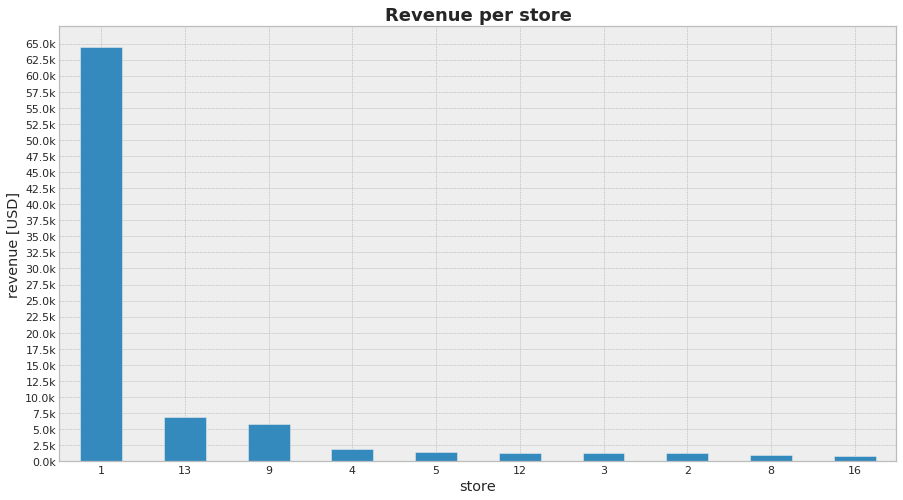

In [460]:
stores_showed = 10
figsize = (15,8)
step = 2500
min_ = float(revenue.min())
max_ = float(revenue.max()+step)
human = False
# Draw plot
fig = revenue.nlargest(stores_showed, 'revenue').plot(kind='bar', 
                                                      stacked=True, 
                                                      figsize=figsize)

# Decorations
fig.set_yticks(np.arange(min_, max_, step))
if human:
    y_ticks = [f'{intword(x)}' for x in fig.get_yticks()]
else:
    y_ticks = ['{:,.1f}'.format(x) + 'k' for x in fig.get_yticks()/1000]
fig.set_yticklabels(y_ticks)
fig.set_title('Revenue per store', fontdict={'size':18, 'weight':'bold'})
fig.set_ylabel('revenue [USD]')
fig.legend().remove()
fig.tick_params(labelrotation=0)
plt.show()

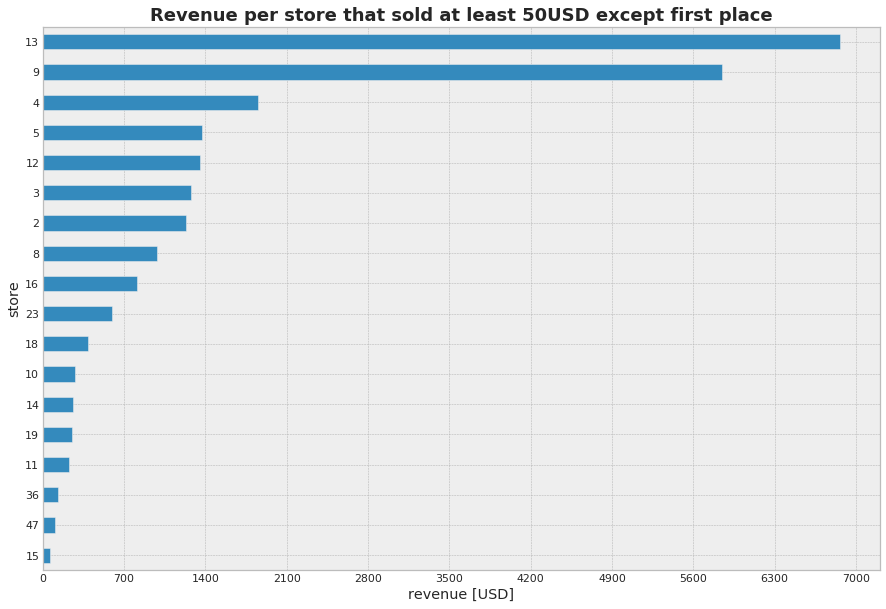

In [461]:
figsize = (15,10)

# Filter df by store that sold at least 50usd, except first place
least = 50
plot_df = revenue[revenue.revenue>least].sort_values(by='revenue', ascending=False).iloc[1:]
bins = 10
min_ = 0
max_ = round(float(plot_df.max()), -3) # Round nearest 1000

# Draw plot
fig = plot_df.sort_values(by='revenue').plot(kind='barh', 
                                             figsize=figsize)
# Decorations
fig.set_xticks(np.linspace(min_, max_, bins+1))
fig.set_xlabel('revenue [USD]')
fig.set_title('Revenue per store that sold at least 50USD except first place', 
              fontdict={'size':18, 
                        'weight':'bold'})
fig.legend().remove()
plt.show()

## Proporción por medio de pago
Primero se filtro por medio de pago, *i.e.* ```pay``` y luego se agrupó por ```store``` calculando la suma total. Este procedimiento se debe realizar dos veces, una por método de pago, pero con la función ```get_revenue_by_pay_method``` es posible obtener este cálculo extendiendolo a $n$ métodos de pago.

In [467]:
df.head()

,order,product,pay,total,created,dist,user,store
0,35394843,2090144731,cash,0.621209,2019-04-15 13:40:19+00:00,488,8540,5
1,35419116,2090144731,cc,2.830394,2019-04-16 20:54:24+00:00,4761,3990,14
2,35404241,2090144731,cash,0.048032,2019-04-15 21:12:49+00:00,3141,19052,5
3,35405366,2090144731,cash,0.128084,2019-04-15 21:58:28+00:00,3070,16978,14
4,35406544,2090144731,cash,3.067619,2019-04-15 23:36:01+00:00,1210,9521,5


### Método 1

In [462]:
def get_revenue_by_pay_method(df:pd.DataFrame, pay_method:str)->pd.DataFrame:
    # Filter and group-by
    gb = df[df.pay==pay_method].groupby(by='store').sum().total
    
    # Transform to DataFrame
    revenue_per_pay_method = gb.to_frame().rename(columns={'total':f'revenue_{pay_method}'})
    
    # Get final df
    return revenue_per_pay_method

In [463]:
# Get revenue per payment method
revenue_cc = get_revenue_by_pay_method(df,'cc')
revenue_cash = get_revenue_by_pay_method(df,'cash')

In [464]:
# Concat dfs
my_df = pd.concat([revenue, revenue_cc, revenue_cash], axis=1).fillna(0).astype(int)

In [465]:
# Revenue per df
my_df['pct_cc'] = my_df.revenue_cc/my_df.revenue
my_df['pct_cash'] = my_df.revenue_cash/my_df.revenue
my_df.fillna(0, inplace=True)

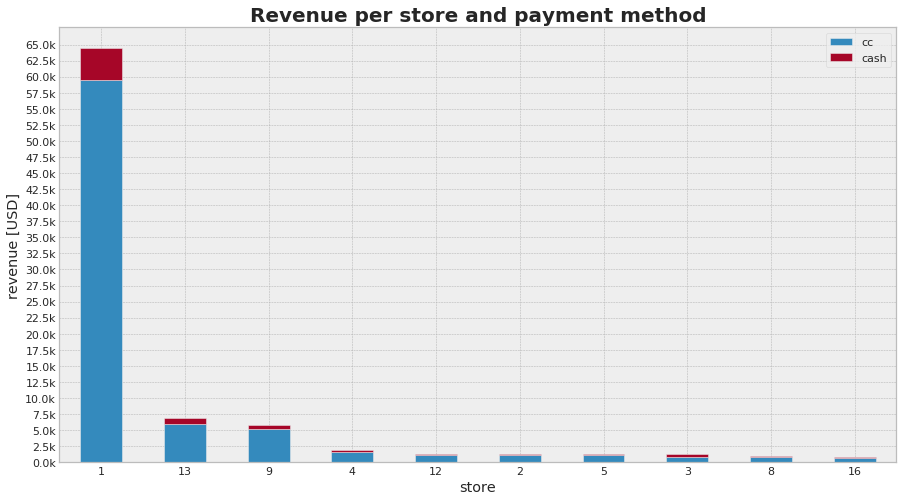

In [466]:
stores_showed = 10
figsize = (15,8)
step = 2500
min_ = float(revenue.min())
max_ = float(revenue.max()+step)
# Draw plot
fig = my_df.loc[:,'revenue_cc':'revenue_cash'].nlargest(stores_showed, 'revenue_cc').plot(kind='bar', 
                                                                                          stacked=True, 
                                                                                          figsize=figsize)

# Decorations
fig.set_yticks(np.arange(min_, max_, step))
#y_ticks = [f'{intword(x)} USD' for x in list(fig.get_yticks())]
y_ticks = ['{:,.1f}'.format(x) + 'k' for x in fig.get_yticks()/1000]
fig.set_yticklabels(y_ticks)
fig.set_ylabel('revenue [USD]')
fig.set_title('Revenue per store and payment method', fontdict={'size':20, 'weight':'bold'})
fig.legend(['cc','cash'])
fig.tick_params(labelrotation=0)
plt.show()

### Método 2

In [468]:
def get_pct_by_pay_method(df:pd.DataFrame, pay_method:str)->pd.DataFrame:
    # Filter and group-by
    revenue_per_store = get_revenue_per_store(df)
    revenue_per_store_filtered = df[df.pay==pay_method].groupby(by='store').sum().total.to_frame() \
    .rename(columns={'total':f'revenue_{pay_method}'})
    
    # Match total and revenue per pay method
    temp_df = pd.concat([revenue_per_store, revenue_per_store_filtered], axis=1).fillna(0)
    
    # Show temporal df
    if DEBUG:
        display(temp_df.head(10))
        
    # Get final df
    pct_by_pay_method = (temp_df[f'revenue_{pay_method}']/temp_df['revenue']).to_frame() \
    .rename(columns={0:f'pct_{pay_method}'})
    return pct_by_pay_method

In [469]:
pct_by_pay_cc = get_pct_by_pay_method(df,'cc')
pct_by_pay_cash = get_pct_by_pay_method(df,'cash')

,revenue,revenue_cc
store,,
1,64438.768164,59460.093634
2,1234.247330,1065.342014
3,1277.482395,890.616774
4,1856.927791,1588.810256
5,1370.054336,1064.200736
6,46.649949,33.060879
7,1.217121,1.217121
8,987.000437,836.005140
9,5845.515493,5161.676677


,revenue,revenue_cash
store,,
1,64438.768164,4978.674530
2,1234.247330,168.905316
3,1277.482395,386.865621
4,1856.927791,268.117535
5,1370.054336,305.853600
6,46.649949,13.589070
7,1.217121,0.000000
8,987.000437,150.995297
9,5845.515493,683.838816


In [470]:
# Create ranking
ranking_df = pd.concat([revenue, pct_by_pay_cc, pct_by_pay_cash], axis=1).fillna(0)

In [471]:
ranking_df.sort_values(by='revenue', ascending=False).head(10)

,revenue,pct_cc,pct_cash
store,,,
1,64438.768164,0.922738,0.077262
13,6861.660906,0.862659,0.137341
9,5845.515493,0.883015,0.116985
4,1856.927791,0.855612,0.144388
5,1370.054336,0.776758,0.223242
12,1353.521340,0.836998,0.163002
3,1277.482395,0.697166,0.302834
2,1234.247330,0.863151,0.136849
8,987.000437,0.847016,0.152984


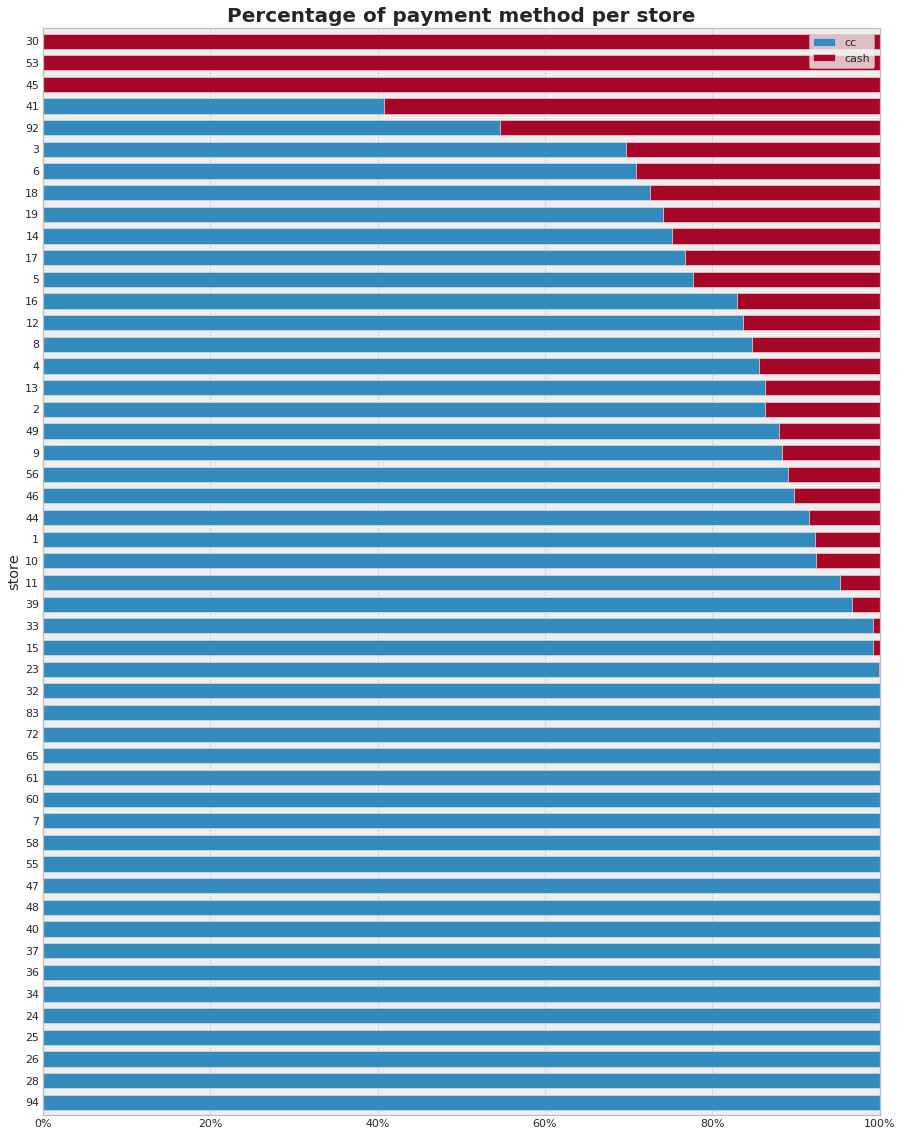

In [472]:
# Draw plot
plot_df = ranking_df[(ranking_df.pct_cc>0) | (ranking_df.pct_cash>0)]
order_by = 'cash'
fig = plot_df.loc[:,'pct_cc':'pct_cash'].sort_values(by=f'pct_{order_by}').plot(kind='barh',
                                                                                stacked=True,
                                                                                figsize=(15,20), 
                                                                                grid=True, 
                                                                                width=0.7)

# Decorations
fig.set_title('Percentage of payment method per store', fontdict={'size':20, 
                                                                  'weight':'bold'})
fig.legend(['cc','cash'])
fig.tick_params(labelrotation=0)
fig.set_xlim(0,1)
fig.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## AOV
El ```aov``` (valor medio de la orden) se calcula de la siguiente manera:
$$\texttt{AOV} = \frac{\texttt{revenue}}{\texttt{orders}}$$

In [473]:
def get_orders_per_store(df:pd.DataFrame)->pd.DataFrame:
    orders = df.groupby(by='store').count().order.rename('orders').to_frame()
    return orders

In [474]:
def get_aov_per_store(df:pd.DataFrame)->pd.DataFrame:
    orders = get_orders_per_store(df)
    revenue = get_revenue_per_store(df)
    temp_df = pd.concat([orders, revenue], axis=1)
    aov = (temp_df.revenue/temp_df.orders).to_frame().rename(columns={0:'aov'})
    return aov

In [475]:
aov = get_aov_per_store(df)

In [476]:
ranking_df = ranking_df.join(aov)

In [477]:
ranking_df.sort_values(by='revenue', ascending=False).head(10)

,revenue,pct_cc,pct_cash,aov
store,,,,
1,64438.768164,0.922738,0.077262,9.939653
13,6861.660906,0.862659,0.137341,5.484941
9,5845.515493,0.883015,0.116985,4.330011
4,1856.927791,0.855612,0.144388,2.852424
5,1370.054336,0.776758,0.223242,1.856442
12,1353.521340,0.836998,0.163002,1.744229
3,1277.482395,0.697166,0.302834,2.718048
2,1234.247330,0.863151,0.136849,3.438015
8,987.000437,0.847016,0.152984,1.258929


In [478]:
# Clear empty values
ranking_df = ranking_df[ranking_df.aov>0]

In [479]:
# Compute z-score
x = ranking_df.aov
ranking_df['aov_z'] = (x - x.mean())/x.std()
ranking_df['colors'] = ['red' if x < 0 else 'green' for x in ranking_df['aov_z']]
ranking_df.sort_values('aov', inplace=True)

In [480]:
# Set store as index
ranking_df.index = ranking_df.index.astype(str)

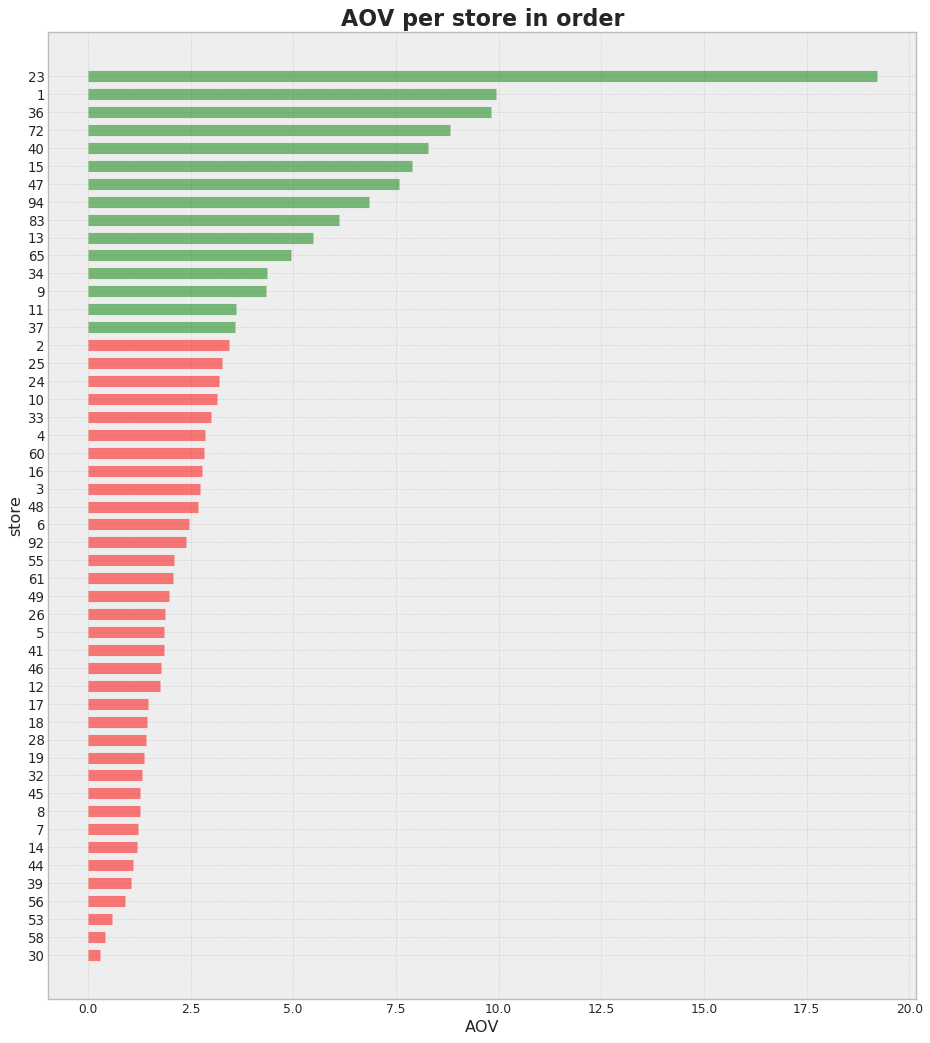

In [481]:
# Draw plot
plt.figure(figsize=(14,16), dpi=80)
plt.hlines(y=ranking_df.index,
           xmin=0,
           xmax=ranking_df.aov,
           color=ranking_df.colors,
           alpha=0.5,
           linewidth=10)

# Decorations
plt.gca().set(ylabel='store', xlabel='AOV')
plt.yticks(ranking_df.index, fontsize=12)
plt.title('AOV per store in order', 
          fontdict={'size':20, 
                    'weight':'bold'})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

## Análisis de producto
Se realizará un análisis por producto tomando en cuenta 3 variables:
- **Ganancia total**.
- **Distancia media**.
- **Cantidad de ordenes**.

Consideración:
- ➕ Productos con mayor cantidad de ganancias, ordenes y menor distancia.
- ➖ Productos con menores ganancias, ordenes y mayor distancia en ese orden.

In [482]:
# Create DataFrames
product_total = df.groupby(by='product').total.sum().to_frame()#.sort_values(by='total', ascending=False)
product_dist = df.groupby(by='product').dist.mean().to_frame()
product_orders = df.groupby(by='product').order.count().to_frame()

# Concat
product_df = pd.concat([product_total, product_dist, product_orders], axis=1)

# For plotting
product_df['product'] = product_df.index

In [485]:
product_df

,total,dist,order,product
product,,,,
2616,133.770831,2481.376812,69,2616
2618,28.081463,3377.800000,15,2618
2620,57.111522,3033.333333,33,2620
2624,0.632863,2292.000000,1,2624
2625,2.524605,3184.000000,3,2625
2626,36.359639,4161.625000,16,2626
2627,0.000000,7592.000000,1,2627
2628,5.174849,1832.500000,4,2628
2629,6.473461,2686.000000,3,2629


In [483]:
if DEBUG:
    product_df.sort_values(by='total', ascending=False).head(10)

In [484]:
log_x = True
log_y = False

# Draw plot
fig = px.scatter(product_df, 
                 x="dist",
                 y="order",
                 log_x=log_x,
                 log_y=log_y,
                 size='total',
                 size_max=35,
                 hover_data=['product']
                )

# Set tile
fig.update_layout(
    title='<b>Orders vs distance per product</b>',
    font=dict(
        size=16,
    )
)

# Set axis
fig.update_layout(
    xaxis_title="Distance",
    yaxis_title="Orders",
    font=dict(
        size=14,
    )
)

fig.show()

## Serie temporal

In [486]:
ts = df.set_index(df.created)

In [487]:
min_date = ts.index.min()
max_date = ts.index.max()

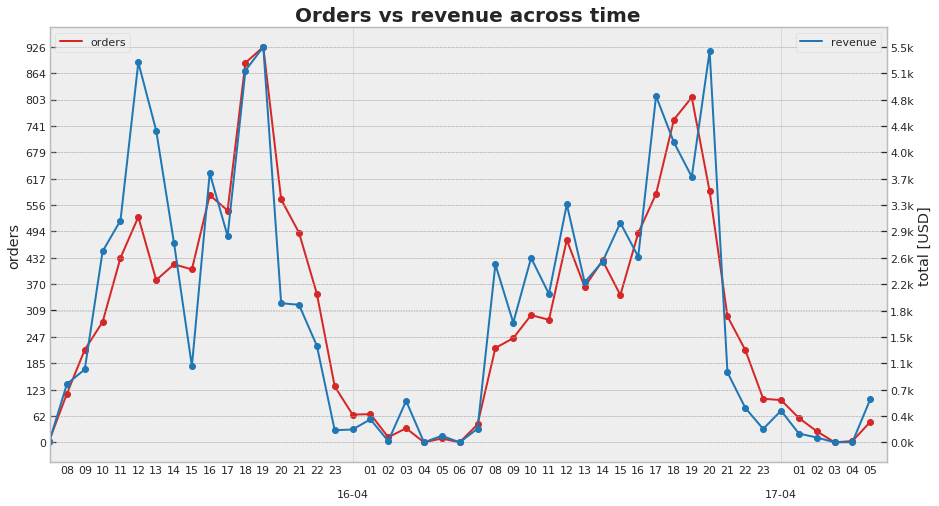

In [491]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Compute df to plot
t = '1H'
ts_orders = ts.resample(t).order.count().to_frame()
ts_total = ts.resample(t).total.sum().to_frame()

# Variables
steps = 15
ax1_yticks=np.round(np.linspace(ts_orders.min(), ts_orders.max(), steps+1),0)
ax2_yticks=np.linspace(ts_total.min(), ts_total.max(), steps+1)
ax1_color='tab:red'
ax2_color='tab:blue'

# Draw plot
fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(ts_orders, color=ax1_color, label='orders', linewidth=2)
ax1.plot(ts_orders, 'o', color=ax1_color)

# Decorate
#ax1.set_xlabel('date')
ax1.set_ylabel('orders')
ax1.tick_params(axis='y')
ax1.set_yticks(ax1_yticks)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Draw plot
ax2.plot(ts_total, color=ax2_color, label='revenue')
ax2.plot(ts_total, 'o', color=ax2_color)

# Decorate
ax2.set_ylabel('total')
ax2.set_yticks(ax2_yticks)
ax2_ytickslabels = ["%.1fk" % x for x in list(ax2.get_yticks()/1000)]
#ax2_ytickslabels = ['{:,.1f}'.format(x) + 'k' for x in ax2_yticks/1000]
ax2.set_yticklabels(ax2_ytickslabels)
ax2.legend(loc='upper right')
ax2.set_ylabel('total [USD]')
ax2.set_xlim(min_date,max_date)
plt.title('Orders vs revenue across time', 
          fontdict={'size':20, 
                    'weight':'bold'})

# Define the date format
ax1.xaxis.set(
    major_locator=mdates.DayLocator(),
    major_formatter=mdates.DateFormatter("\n\n%d-%m"),
    minor_locator=mdates.HourLocator(interval=1),
    minor_formatter=mdates.DateFormatter("%H"),
)

plt.show()

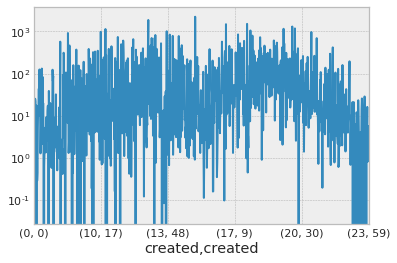

In [363]:
hour_df = pd.concat([ts.groupby([ts.index.hour, ts.index.minute])[['total','dist']].sum(), \
                     ts.groupby([ts.index.hour, ts.index.minute])[['order']].count()], axis=1)

hour_df.total.plot(logy=True)
#hour_df.dist.plot()
#hour_df.order.plot()